In [ ]:
!pip install earth2studio[dlwp] earth2studio[pangu] earth2studio[sfno] earth2studio[cyclone] cartopy "makani @ git+https://github.com/NVIDIA/modulus-makani.git@28f38e3e929ed1303476518552c64673bbd6f722"

# !git clone https://github.com/NVIDIA/makani.git
# %cd makani
# !pip install -e .
# %cd ..


  Using cached makani-0.2.0-py3-none-any.whl


In [ ]:
import numpy as np
import xarray as xr
import torch
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

from tqdm import tqdm

from earth2studio.models.px import SFNO
from earth2studio.models.dx import TCTrackerWuDuan, TCTrackerVitart
from earth2studio.data import GFS, ARCO, fetch_data, prep_data_array
from earth2studio.utils.time import to_time_array
from earth2studio.utils.coords import map_coords
from earth2studio.perturbation import (
    CorrelatedSphericalGaussian,
    HemisphericCentredBredVector,
)

import logging

logging.getLogger("earth2studio.data").setLevel(logging.WARNING)

# ---- device ----
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available – check your WSL2/NVIDIA setup")
device = torch.device("cuda:0")

# ---- models ----
sfno = SFNO.load_model(SFNO.load_default_package()).to(device)

tc_tracker = TCTrackerWuDuan().to(device)
# tc_tracker = TCTrackerVitart().to(device)

# ---- data sources ----
gfs = GFS()
era5 = ARCO()

seed_perturbation = CorrelatedSphericalGaussian(noise_amplitude=0.1)
perturbation_model = HemisphericCentredBredVector(
    sfno, era5, seed_perturbation, noise_amplitude=0.1
)

2025-12-07 20:37:25.457 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs to local cache
2025-12-07 20:37:25.493 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup to local cache
2025-12-07 20:37:25.497 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata to local cache
2025-12-07 20:37:25.559 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/level/0 to local cache
2025-12-07 20:37:25.585 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/.zattrs to local cache
2025-12-07 20:37:25.671 | DEBUG    | earth2studio.data.utils:_make_local_details:657 -

In [ ]:
def get_initial_state(model, data_source, start_times, device):
    """
    Fetch and map initial condition to the model's prognostic grid.
    start_times: list of ISO strings, e.g. ["2017-08-25T00:00"]
    """
    prognostic_ic = model.input_coords()
    time = to_time_array(start_times)

    x0, coords0 = fetch_data(
        source=data_source,
        time=time,
        variable=prognostic_ic["variable"],
        lead_time=prognostic_ic["lead_time"],
        device=device,
        interp_to=prognostic_ic if hasattr(model, "interp_method") else None,
        interp_method=getattr(model, "interp_method", "nearest"),
    )

    x0, coords0 = map_coords(x0, coords0, prognostic_ic)
    return x0, coords0


def integrate_model(model, x_init, coords_init, nsteps: int,
                    include_init: bool = True, store_dtype=torch.float16, ):
    """
    Run the model iterator and return:
      - xs: list of tensors on CPU
      - coords_list: list of coord dicts

    If include_init=True:
      xs = [x^0, x^1, ..., x^nsteps]  (length nsteps+1)
      coords_list = [coords^0, coords^1, ..., coords^nsteps]

      where x^0, coords^0 are the initial condition you passed in.

    If include_init=False:
      xs = [x^1, ..., x^nsteps]       (length nsteps)
    """
    xs = []
    coords_list = []

    # helper: convert to cpu + desired dtype
    def _store(x):
        # don't mutate x; just create a compressed CPU copy
        return x.detach().to(store_dtype).cpu()

    # optionally store the initial state as step 0
    if include_init:
        xs.append(_store(x_init))
        coords_list.append(coords_init)

    it = model.create_iterator(x_init.clone(), coords_init)

    # we still want exactly nsteps model advances
    # so that total length is nsteps+1 when include_init=True
    for step, (x_step, coords_step) in enumerate(it, start=1 if include_init else 0):
        xs.append(_store(x_step))
        coords_list.append(coords_step)
        if step == nsteps:
            break

    return xs, coords_list


def build_sequence_da(
    ctrl_steps,
    coords0,
    step_hours: int,
    pert_steps=None,
    name_ctrl="control",
    name_pert="perturbed",
):
    """
    Turn lists of tensors into xarray DataArrays:
    x_ctrl, x_pert, x_diff (latter two may be None if pert_steps is None).
    """
    ctrl_np = np.stack([t.numpy() for t in ctrl_steps], axis=0)  # (step, ...)

    dim_names = list(coords0.keys())
    coords_for_xr = {}

    for name in dim_names:
        arr = np.array(coords0[name])
        # Drop numeric coords to float32 instead of float64
        if np.issubdtype(arr.dtype, np.floating):
            arr = arr.astype("float32")
        coords_for_xr[name] = arr

    n_steps = ctrl_np.shape[0]
    step_vals = np.arange(n_steps)
    lead_hours = step_hours * step_vals

    coords_full = {
        "step": step_vals,
        "lead_hours": ("step", lead_hours),
    }
    coords_full.update(coords_for_xr)

    x_ctrl = xr.DataArray(
        ctrl_np,
        dims=("step",) + tuple(dim_names),
        coords=coords_full,
        name=name_ctrl,
    )

    if pert_steps is None:
        return x_ctrl, None, None

    pert_np = np.stack([t.numpy() for t in pert_steps], axis=0)
    x_pert = xr.DataArray(
        pert_np,
        dims=("step",) + tuple(dim_names),
        coords=coords_full,
        name=name_pert,
    )

    x_diff = (x_pert.astype("float32") - x_ctrl.astype("float32")).astype("float16")
    x_diff.name = f"{name_pert}_minus_{name_ctrl}"

    return x_ctrl, x_pert, x_diff


In [ ]:
def plot_forecast_sequence(
    x_ctrl,
    target_var: str,
    x_pert=None,
    x_diff=None,
    steps_to_show=None,
):
    """
    If x_pert/x_diff provided:
      - plot RMS growth vs lead time
      - for each chosen step: control / perturbed / difference maps

    If only x_ctrl provided:
      - plot the control map over time (single panel per step).
    """
    # Take the first (time, lead_time) slice as before
    ctrl_var = x_ctrl.sel(variable=target_var).isel(time=0, lead_time=0)

    lead_hours = x_ctrl["lead_hours"].values

    if steps_to_show is None:
        steps_to_show = range(ctrl_var.sizes["step"])

    # If perturbed forecast is provided, plot RMS and triptychs
    if x_pert is not None and x_diff is not None:
        pert_var = x_pert.sel(variable=target_var).isel(time=0, lead_time=0)
        diff_var = x_diff.sel(variable=target_var).isel(time=0, lead_time=0)

        # RMS growth vs lead time (unchanged)
        rms_by_step = np.sqrt((diff_var ** 2).mean(dim=("lat", "lon")))

        plt.figure(figsize=(8, 4))
        rms_by_step.plot(x="lead_hours", marker="o")
        plt.xlabel("Lead time (hours)")
        plt.ylabel(f"RMS difference in {target_var}")
        plt.title(f"Growth of perturbation in {target_var}")
        plt.grid(True)
        plt.show()

        # Triptych maps with Cartopy
        for k in steps_to_show:
            ctrl_k = ctrl_var.sel(step=k)
            pert_k = pert_var.sel(step=k)
            diff_k = diff_var.sel(step=k)

            fig = plt.figure(figsize=(15, 4))

            # --- Control ---
            ax0 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
            ctrl_k.plot(
                ax=ax0,
                x="lon",
                y="lat",
                transform=ccrs.PlateCarree(),
            )
            ax0.coastlines()
            ax0.add_feature(cfeature.LAND, alpha=0.2)
            ax0.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax0.set_title(f"Control {target_var}, +{int(lead_hours[k])} h")

            # --- Perturbed ---
            ax1 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
            pert_k.plot(
                ax=ax1,
                x="lon",
                y="lat",
                transform=ccrs.PlateCarree(),
            )
            ax1.coastlines()
            ax1.add_feature(cfeature.LAND, alpha=0.2)
            ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax1.set_title(f"Perturbed {target_var}, +{int(lead_hours[k])} h")

            # --- Difference ---
            ax2 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
            diff_k.plot(
                ax=ax2,
                x="lon",
                y="lat",
                transform=ccrs.PlateCarree(),
            )
            ax2.coastlines()
            ax2.add_feature(cfeature.LAND, alpha=0.2)
            ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax2.set_title(f"Difference, +{int(lead_hours[k])} h")

            plt.tight_layout()
            plt.show()

    # If no perturbed forecast, just show control maps
    else:
        for k in steps_to_show:
            ctrl_k = ctrl_var.sel(step=k)

            fig = plt.figure(figsize=(6, 4))
            ax = plt.axes(projection=ccrs.PlateCarree())

            ctrl_k.plot(
                ax=ax,
                x="lon",
                y="lat",
                transform=ccrs.PlateCarree(),
            )
            ax.coastlines()
            ax.add_feature(cfeature.LAND, alpha=0.2)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_title(f"{target_var}, +{int(lead_hours[k])} h (control)")

            plt.tight_layout()
            plt.show()

In [ ]:
def run_tc_on_reanalysis(tc_model, data_source, start_time, nsteps, device):
    """
    Run TC tracker directly on a data source (e.g. ERA5 via ARCO or GFS).
    Returns the final output tensor (same thing you were calling `output`),
    moved to CPU.
    """
    tc_model.reset_path_buffer()

    times = [start_time + timedelta(hours=6 * i) for i in range(nsteps + 1)]
    for step, t in enumerate(times):
        da = data_source(t, tc_model.input_coords()["variable"])
        x, coords = prep_data_array(da, device=device)
        output, output_coords = tc_model(x, coords)
        # you were just printing shapes per step; last 'output' carries tracks
        print(f"Step {step}: {data_source.__class__.__name__} tracks output shape {output.shape}")

    return output.detach().cpu()


def run_tc_on_forecast(tc_model, forecast_steps, forecast_coords, device):
    """
    Run TC tracker on a SFNO forecast sequence:
      forecast_steps: list of CPU tensors (from integrate_model)
      forecast_coords: list of coords dicts (same length)
    Returns final output tensor with tracks on CPU.
    """
    tc_model.reset_path_buffer()
    last_output = None

    for step, (x_cpu, coords) in enumerate(zip(forecast_steps, forecast_coords)):
        x = x_cpu.to(device)
        x_tc, coords_tc = map_coords(x, coords, tc_model.input_coords())

        # --- SANITY GUARD: remove NaNs / infs before tracker ---
        x_tc = torch.nan_to_num(
            x_tc,
            nan=0.0,
            posinf=1e4,
            neginf=-1e4,
        )

        try:
            output, output_coords = tc_model(x_tc, coords_tc)
        except Exception as e:
            print(f"[WARN] Tracker failed at forecast step {step}: {e}")
            # Skip this step; keep previous path_buffer / last_output
            continue

        # remove lead_time dim (tc trackers have lead_time=1)
        output = output[:, 0]
        last_output = output  # remember last successful tracks
        print(f"Step {step}: forecast tracks output shape {output.shape}")


    if last_output is None:
        raise RuntimeError("TC tracker never produced a valid output on forecast.")
    return last_output.detach().cpu()



In [ ]:
def _tracks_to_numpy(tracks):
    """Normalize torch.Tensor or array-like to a NumPy array."""
    if isinstance(tracks, torch.Tensor):
        return tracks.detach().cpu().numpy()
    return np.asarray(tracks)


def plot_tc_tracks(
    tracks1,
    tracks2=None,
    labels=("Run 1", "Run 2"),
    region=(-180, 180, -90, 90),
    start_time=None,
    step_hours=6,
    nsteps=None,
    cmap1=plt.cm.autumn,
    cmap2=plt.cm.winter,
):
    """
    Plot cyclone tracks for one or two runs on a single map.

    Visualization:
      • tracks1 = solid lines (default)
      • tracks2 = X markers only (no solid line), so overlaps are visible
    """
    tracks1_np = _tracks_to_numpy(tracks1)
    tracks2_np = _tracks_to_numpy(tracks2) if tracks2 is not None else None

    lon_min, lon_max, lat_min, lat_max = region

    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(
        1, 1,
        figsize=(10, 8),
        subplot_kw={"projection": projection},
    )

    # Base map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.gridlines(draw_labels=True, alpha=0.6)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # ---- Plot tracks1 (solid lines) ----
    n1 = tracks1_np.shape[1]
    for path in range(n1):
        lats = tracks1_np[0, path, :, 0]
        lons = tracks1_np[0, path, :, 1]
        mask = ~np.isnan(lats) & ~np.isnan(lons)
        if mask.any() and len(lons[mask]) > 2:
            color = cmap1(path / max(1, n1))
            ax.plot(
                lons[mask],
                lats[mask],
                color=color,
                linewidth=2.0,
                linestyle="-",
                transform=ccrs.PlateCarree(),
                label=labels[0] if path == 0 else None,
            )

    # ---- Plot tracks2 (X markers only, no solid line) ----
    if tracks2_np is not None:
        n2 = tracks2_np.shape[1]
        for path in range(n2):
            lats = tracks2_np[0, path, :, 0]
            lons = tracks2_np[0, path, :, 1]
            mask = ~np.isnan(lats) & ~np.isnan(lons)
            if mask.any() and len(lons[mask]) > 2:
                color = cmap2(path / max(1, n2))

                # KEY CHANGE:
                # marker 'x', no connecting line
                ax.plot(
                    lons[mask],
                    lats[mask],
                    color=color,
                    marker="x",
                    markersize=6,
                    linestyle="",
                    transform=ccrs.PlateCarree(),
                    label=labels[1] if path == 0 else None,
                )

    # Legend
    handles = []
    handles.append(mpatches.Patch(color=cmap1(0.5), label=labels[0]))
    if tracks2_np is not None:
        handles.append(mpatches.Patch(color=cmap2(0.5), label=labels[1]))

    ax.legend(handles=handles, loc="upper right", title="Cyclone Runs")

    # Title
    if start_time is not None and nsteps is not None:
        end_time = start_time + timedelta(hours=step_hours * nsteps)
        ax.set_title(
            f"Cyclone Track Comparison\n{start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')}"
        )

    plt.tight_layout()
    plt.show()


In [ ]:
def _gaussian_mask_latlon(lat, lon, center_lat, center_lon, radius_deg):
    """
    Build a (lat, lon) Gaussian mask centered at (center_lat, center_lon)
    with e-folding radius = radius_deg (in degrees).

    Uses a simple lat/lon metric with dateline wrapping for lon.
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)

    # 2D grids (lat, lon) with shape (nlat, nlon)
    lat2d, lon2d = np.meshgrid(lat, lon, indexing="ij")

    dlat = lat2d - center_lat
    dlon = lon2d - center_lon

    # wrap longitude difference to [-180, 180]
    dlon = (dlon + 180.0) % 360.0 - 180.0

    # approximate isotropic distance in degrees
    # scale lon by cos(phi0) so 1 deg lat ~ 1 deg lon * cos(phi0)
    phi0 = np.deg2rad(center_lat)
    dlon_eff = dlon * np.cos(phi0)

    dist2 = dlat**2 + dlon_eff**2

    # Gaussian with peak 1 at center
    mask = np.exp(-0.5 * dist2 / (radius_deg**2))
    return mask


def apply_gaussian_deep_wind_perturbation(
    x_init,
    coords,
    center_lat,
    center_lon,
    radius_deg=15.0,
    delta_u=1.0,
    delta_v=0.0,
    u_vars=("u850", "u500", "u200"),
    v_vars=("v850", "v500", "v200"),
    level_weights=(1.0, 0.8, 0.5),
):
    """
    Apply a smooth Gaussian perturbation to deep-layer winds (u, v)
    in a way that changes the steering flow but keeps the vortex intact.

    Parameters
    ----------
    x_init : torch.Tensor
        Input state [batch, ..., variable, lat, lon] (dims inferred from coords).
    coords : dict-like
        Must contain "variable", "lat", "lon" consistent with x_init.
    center_lat, center_lon : float
        Center of the Gaussian perturbation (deg).
    radius_deg : float
        E-folding radius of the Gaussian (deg). ~10–20 is reasonable.
    delta_u, delta_v : float
        Peak perturbation (m/s) for the deep-layer mean at the center.
        Sign and ratio set the direction of the steering nudge.
    u_vars, v_vars : sequence of str
        Variable names for u and v at each level (same length).
    level_weights : sequence of float
        Relative weight for each level (same length as u_vars/v_vars).
        Typically something like (1.0, 0.8, 0.5) so lower levels get
        slightly stronger perturbation.

    Returns
    -------
    x_pert : torch.Tensor
        Perturbed state on same device/dtype as x_init.
    """
    assert len(u_vars) == len(v_vars) == len(level_weights), \
        "u_vars, v_vars, and level_weights must have same length"

    dim_names = list(coords.keys())
    axis = {name: i for i, name in enumerate(dim_names)}

    var_names = np.array(coords["variable"])
    lat = np.array(coords["lat"])
    lon = np.array(coords["lon"])

    # Build Gaussian mask in numpy with shape (nlat, nlon)
    mask = _gaussian_mask_latlon(lat, lon, center_lat, center_lon, radius_deg)
    # Cast to x dtype
    x_np = x_init.detach().cpu().numpy()
    mask = mask.astype(x_np.dtype, copy=False)

    x_np_pert = x_np.copy()

    # Prepare index template
    base_idx = [slice(None)] * x_np.ndim

    # Add perturbations at each level
    for (u_name, v_name, w) in zip(u_vars, v_vars, level_weights):
        # Find variable indices
        try:
            u_idx = int(np.where(var_names == u_name)[0][0])
            v_idx = int(np.where(var_names == v_name)[0][0])
        except IndexError:
            # If a requested level isn't present, skip gracefully
            continue

        # u-level
        idx_u = list(base_idx)
        idx_u[axis["variable"]] = u_idx
        idx_u[axis["lat"]] = slice(None)
        idx_u[axis["lon"]] = slice(None)
        # Broadcast mask over remaining dims
        x_np_pert[tuple(idx_u)] += (delta_u * w) * mask

        # v-level
        idx_v = list(base_idx)
        idx_v[axis["variable"]] = v_idx
        idx_v[axis["lat"]] = slice(None)
        idx_v[axis["lon"]] = slice(None)
        x_np_pert[tuple(idx_v)] += (delta_v * w) * mask

    # Back to torch, preserving device/dtype
    return torch.from_numpy(x_np_pert).to(device=x_init.device, dtype=x_init.dtype)

def apply_box_perturbation(
    x_init,
    coords,
    target_var: str,
    delta: float,
    lat_range,
    lon_range,
):
    """
    Add 'delta' to target_var in a lat/lon box.
    lat_range, lon_range: (min, max)
    Returns a new tensor on the same device as x_init.
    """
    dim_names = list(coords.keys())  # e.g. ["time", "lead_time", "variable", "lat", "lon"]
    axis = {name: i for i, name in enumerate(dim_names)}

    var_names = np.array(coords["variable"])
    lat = np.array(coords["lat"])
    lon = np.array(coords["lon"])

    var_idx = int(np.where(var_names == target_var)[0][0])
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)

    x_np = x_init.detach().cpu().numpy()

    lat_idx = np.where(lat_mask)[0]
    lon_idx = np.where(lon_mask)[0]
    lat_ix, lon_ix = np.ix_(lat_idx, lon_idx)

    idx = [slice(None)] * x_np.ndim
    idx[axis["variable"]] = var_idx
    idx[axis["lat"]] = lat_ix
    idx[axis["lon"]] = lon_ix

    x_np_pert = x_np.copy()
    x_np_pert[tuple(idx)] += delta

    return torch.from_numpy(x_np_pert).to(x_init.device)

def apply_gaussian_pressure_perturbation(
    x_init,
    coords,
    center_lat: float,
    center_lon: float,
    radius_deg: float = 15.0,
    delta: float = 10.0,
    p_vars=("z500",),
    level_weights=None,
):
    """
    Apply a smooth Gaussian perturbation to large-scale pressure/geopotential
    fields (e.g., z500, z700, mslp) to reshape the steering environment.

    Parameters
    ----------
    x_init : torch.Tensor
        Input state with dims given by coords.keys(), including "variable", "lat", "lon".
    coords : dict-like
        Must contain 1D arrays for "variable", "lat", "lon". lon in [-180, 180], lat in [-90, 90].
    center_lat, center_lon : float
        Center of the Gaussian perturbation in degrees.
    radius_deg : float
        E-folding radius (in degrees of latitude). ~10–20 is typical for synoptic perturbations.
    delta : float
        Peak perturbation amplitude at the center. For z500, think ~+/- 5–20 meters.
        For mslp, you might want something like +/- 50–200 Pa (0.5–2 hPa).
    p_vars : sequence of str
        Names of pressure/geopotential variables to perturb (e.g., ("z500", "z700")).
    level_weights : sequence of float or None
        Relative weights for each variable in p_vars. If None, all 1.0.

    Returns
    -------
    x_pert : torch.Tensor
        Perturbed state on same device and dtype as x_init.
    """
    if level_weights is None:
        level_weights = [1.0] * len(p_vars)
    assert len(p_vars) == len(level_weights), "p_vars and level_weights must match in length"

    dim_names = list(coords.keys())
    axis = {name: i for i, name in enumerate(dim_names)}

    var_names = np.array(coords["variable"])
    lat = np.array(coords["lat"])
    lon = np.array(coords["lon"])

    # Gaussian mask in (lat, lon), lon/lat as [-180,180],[-90,90]
    mask = _gaussian_mask_latlon(lat, lon, center_lat, center_lon, radius_deg)

    x_np = x_init.detach().cpu().numpy()
    mask = mask.astype(x_np.dtype, copy=False)

    x_np_pert = x_np.copy()
    base_idx = [slice(None)] * x_np.ndim

    for var_name, w in zip(p_vars, level_weights):
        matches = np.where(var_names == var_name)[0]
        if matches.size == 0:
            # variable not present -> skip
            continue
        v_idx = int(matches[0])

        idx = list(base_idx)
        idx[axis["variable"]] = v_idx
        idx[axis["lat"]] = slice(None)
        idx[axis["lon"]] = slice(None)

        x_np_pert[tuple(idx)] += (delta * w) * mask

    return torch.from_numpy(x_np_pert).to(device=x_init.device, dtype=x_init.dtype)


def apply_gaussian_sst_perturbation(
    x_init,
    coords,
    center_lat: float,
    center_lon: float,
    radius_deg: float = 5.0,
    delta_sst: float = 0.3,
    sst_var: str = "sst",
    clip_min: float | None = None,
    clip_max: float | None = None,
):
    """
    Apply a smooth Gaussian SST perturbation (e.g., +0.3°C over a patch) to bias
    convection on one side of the storm. Operates only on the SST variable.

    Parameters
    ----------
    x_init : torch.Tensor
        Input state with dims given by coords.keys(), including "variable", "lat", "lon".
    coords : dict-like
        Must contain 1D arrays for "variable", "lat", "lon". lon in [-180, 180], lat in [-90, 90].
    center_lat, center_lon : float
        Center of the Gaussian perturbation (deg).
    radius_deg : float
        E-folding radius (deg). Smaller than pressure, e.g. 3–8°.
    delta_sst : float
        Peak SST perturbation in °C (or K, if your SST is in K).
        Typical: +0.2 to +0.5.
    sst_var : str
        Name of the SST variable in coords["variable"] (e.g., "sst" or "t_surf").
    clip_min, clip_max : float or None
        Optional physical bounds for SST after perturbation (e.g., (271, 310)).

    Returns
    -------
    x_pert : torch.Tensor
        Perturbed state on same device and dtype as x_init.
    """
    dim_names = list(coords.keys())
    axis = {name: i for i, name in enumerate(dim_names)}

    var_names = np.array(coords["variable"])
    lat = np.array(coords["lat"])
    lon = np.array(coords["lon"])

    matches = np.where(var_names == sst_var)[0]
    if matches.size == 0:
        # nothing to do if SST var doesn't exist
        return x_init

    sst_idx = int(matches[0])

    mask = _gaussian_mask_latlon(lat, lon, center_lat, center_lon, radius_deg)

    x_np = x_init.detach().cpu().numpy()
    mask = mask.astype(x_np.dtype, copy=False)

    x_np_pert = x_np.copy()
    base_idx = [slice(None)] * x_np.ndim

    idx = list(base_idx)
    idx[axis["variable"]] = sst_idx
    idx[axis["lat"]] = slice(None)
    idx[axis["lon"]] = slice(None)

    x_np_pert[tuple(idx)] += delta_sst * mask

    if clip_min is not None or clip_max is not None:
        sst_slice = tuple(idx)
        if clip_min is not None:
            x_np_pert[sst_slice] = np.maximum(x_np_pert[sst_slice], clip_min)
        if clip_max is not None:
            x_np_pert[sst_slice] = np.minimum(x_np_pert[sst_slice], clip_max)

    return torch.from_numpy(x_np_pert).to(device=x_init.device, dtype=x_init.dtype)


In [ ]:
# --- forecast setup ---
start_time = datetime(2017, 9, 2)
start_times = [start_time.isoformat()]
nsteps = 25           # 10 steps -> 60 h for SFNO (6 h per step)
step_hours = 6

x0, coords0 = get_initial_state(sfno, era5, start_times, device)

Fetching ARCO data:   0%|          | 0/73 [00:00<?, ?it/s]

2025-12-07 20:37:26.037 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2017-09-02T00:00:00
2025-12-07 20:37:26.040 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: t300 at 2017-09-02T00:00:00
2025-12-07 20:37:26.042 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u50 at 2017-09-02T00:00:00
2025-12-07 20:37:26.044 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: t250 at 2017-09-02T00:00:00
2025-12-07 20:37:26.046 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: q1000 at 2017-09-02T00:00:00
2025-12-07 20:37:26.049 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v925 at 2017-09-02T00:00:00
2025-12-07 20:37:26.052 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: t600 at 2017-

Fetching ARCO data:   0%|          | 0/73 [00:00<?, ?it/s]

2025-12-07 20:37:26.243 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/u_component_of_wind/1031472.0.0.0 to local cache
2025-12-07 20:37:26.245 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/u_component_of_wind/1031472.0.0.0 to local cache
2025-12-07 20:37:26.248 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/1031472.0.0.0 to local cache


Fetching ARCO data:   0%|          | 0/73 [00:00<?, ?it/s]

2025-12-07 20:37:26.480 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/v_component_of_wind/1031472.0.0.0 to local cache
2025-12-07 20:37:26.482 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/v_component_of_wind/1031472.0.0.0 to local cache
2025-12-07 20:37:26.486 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/mean_sea_level_pressure/1031472.0.0 to local cache
2025-12-07 20:37:26.488 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/specific_humidity/1031472.0.0.0 to local cache
2025-12-07 20:37:26.491 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/u_co

Fetching ARCO data: 100%|██████████| 73/73 [00:32<00:00,  2.23it/s]


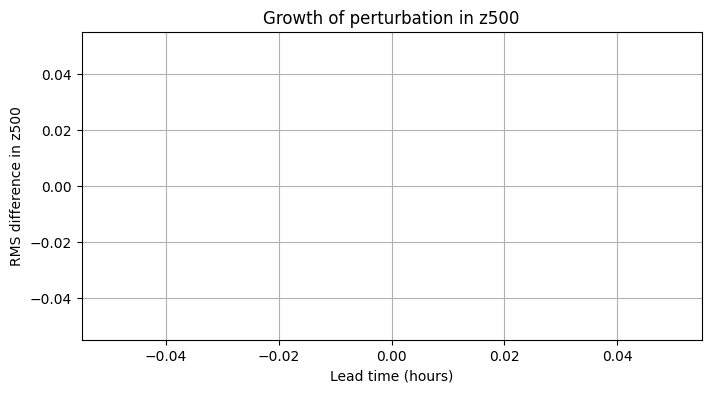

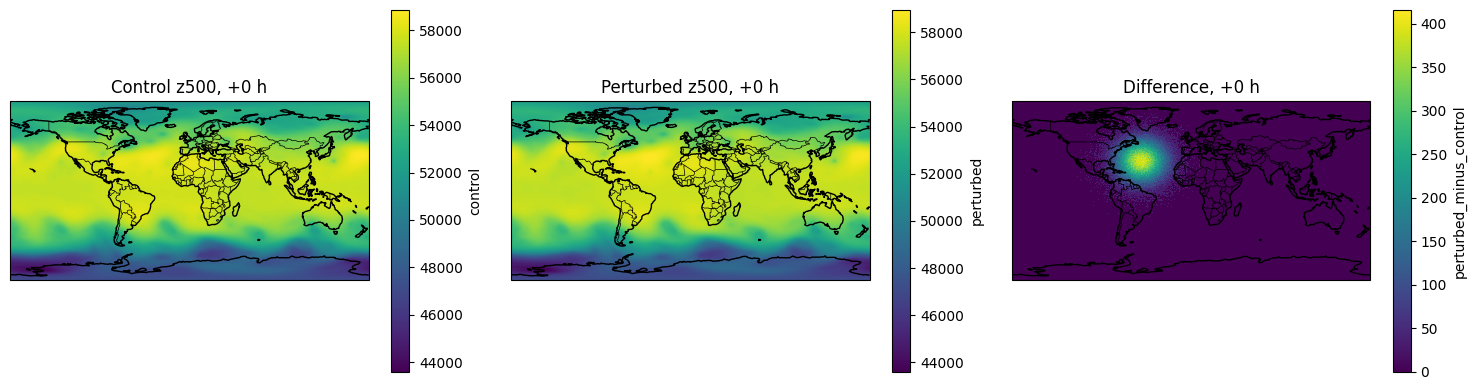

In [ ]:
# control forecast
ctrl_steps, ctrl_coords = integrate_model(sfno, x0, coords0, nsteps)

perturb_lat, pertub_lon = 25, -60

# perturbed initial condition
# x_pert = apply_box_perturbation(
#     x0,
#     coords0,
#     target_var="t850",
#     delta=2.0,
#     lat_range=(10, 40),
#     lon_range=(-80, -40),
# )
# x_pert = apply_gaussian_deep_wind_perturbation(
#     x0,
#     coords0,
#     center_lat=25,
#     center_lon=-60,
#     radius_deg=12.0,
#     delta_u=10.0,    # +1 m/s zonal (eastward)
#     delta_v=10.5,    # +0.5 m/s meridional (northward)
#     u_vars=("u850", "u500", "u200"),
#     v_vars=("v850", "v500", "v200"),
#     level_weights=(1.0, 0.8, 0.5),
# )

x_pert = apply_gaussian_pressure_perturbation(
    x0,
    coords0,
    center_lat=30,
    center_lon=-50,
    radius_deg=15.0,
    delta=9.81 * 40.0,                 # -15 m in z500: deepen trough
    p_vars=("z500",),
    level_weights=(1.0,)
)

# x_pert = apply_gaussian_sst_perturbation(
#     x0,
#     coords0,
#     center_lat=20,
#     center_lon=-45,
#     radius_deg=10.0,
#     delta_sst=0.5,                # +0.3°C
#     sst_var="sst",
#     clip_min=271.0,
#     clip_max=310.0
# )

# x_pert, x_pert_coords = perturbation_model(x0, coords0)

pert_steps, pert_coords = integrate_model(sfno, x_pert, coords0, nsteps)

# build xarray views & plot
x_ctrl, x_pert_da, x_diff = build_sequence_da(
    ctrl_steps,
    coords0,
    step_hours=step_hours,
    pert_steps=pert_steps,
    name_ctrl="control",
    name_pert="perturbed",
)

plot_forecast_sequence(
    x_ctrl,
    target_var="z500",
    x_pert=x_pert_da,
    x_diff=x_diff,
    steps_to_show=range(0, 1, 1),
)


Step 0: forecast tracks output shape torch.Size([1, 5, 1, 4])
Step 1: forecast tracks output shape torch.Size([1, 5, 2, 4])
Step 2: forecast tracks output shape torch.Size([1, 6, 3, 4])
Step 3: forecast tracks output shape torch.Size([1, 7, 4, 4])
Step 4: forecast tracks output shape torch.Size([1, 8, 5, 4])
Step 5: forecast tracks output shape torch.Size([1, 9, 6, 4])
Step 6: forecast tracks output shape torch.Size([1, 10, 7, 4])
Step 7: forecast tracks output shape torch.Size([1, 11, 8, 4])
Step 8: forecast tracks output shape torch.Size([1, 11, 9, 4])
Step 9: forecast tracks output shape torch.Size([1, 12, 10, 4])
Step 10: forecast tracks output shape torch.Size([1, 13, 11, 4])
Step 11: forecast tracks output shape torch.Size([1, 14, 12, 4])
Step 12: forecast tracks output shape torch.Size([1, 15, 13, 4])
Step 13: forecast tracks output shape torch.Size([1, 16, 14, 4])
Step 14: forecast tracks output shape torch.Size([1, 17, 15, 4])
Step 15: forecast tracks output shape torch.Size([

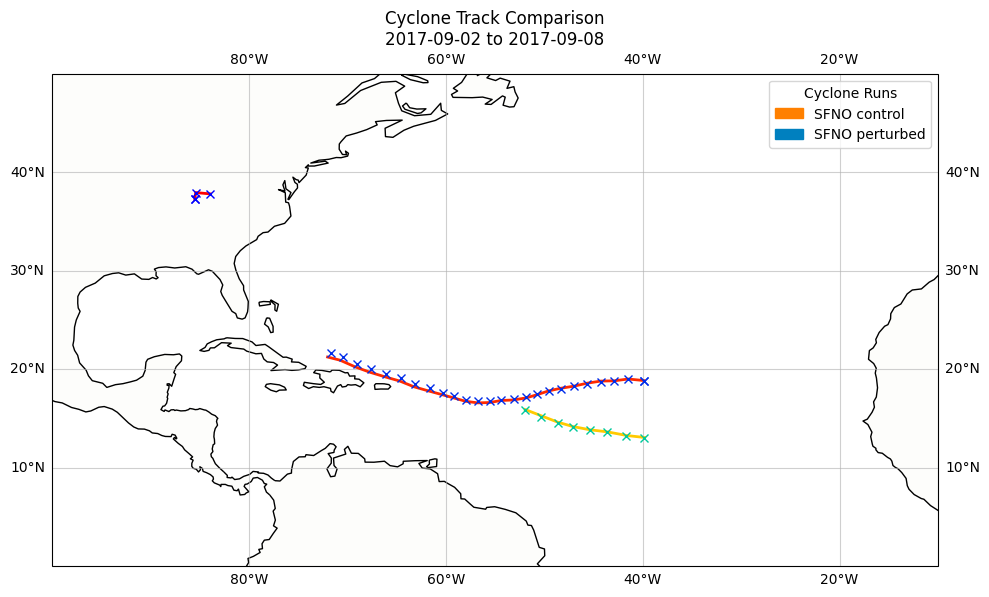

In [ ]:
# --- TC tracker on ERA5 (ARCO) ---
nsteps_tc = 25
# tc_start = datetime(2009, 8, 5)
tc_start = start_time

# era5_tracks = run_tc_on_reanalysis(
#     tc_model=tc_tracker,
#     data_source=era5,   # or gfs if you want GFS
#     start_time=tc_start,
#     nsteps=nsteps_tc,
#     device=device,
# )

# --- TC tracker on control forecast ---
sfno_ctrl_tracks = run_tc_on_forecast(
    tc_model=tc_tracker,
    forecast_steps=ctrl_steps,
    forecast_coords=ctrl_coords,
    device=device,
)

# --- TC tracker on perturbed forecast ---
sfno_pert_tracks = run_tc_on_forecast(
    tc_model=tc_tracker,
    forecast_steps=pert_steps,
    forecast_coords=pert_coords,
    device=device,
)

# --- plot comparisons ---
# ERA5 vs SFNO control
# plot_tc_tracks(
#     era5_tracks,
#     sfno_ctrl_tracks,
#     labels=("ERA5 (ARCO)", "SFNO control"),
#     region=(-100, -10, 0, 50),
#     start_time=tc_start,
#     step_hours=step_hours,
#     nsteps=nsteps_tc,
# )

# SFNO control vs SFNO perturbed
plot_tc_tracks(
    sfno_ctrl_tracks,
    sfno_pert_tracks,
    labels=("SFNO control", "SFNO perturbed"),
    region=(-100, -10, 0, 50),
    start_time=start_time,
    step_hours=step_hours,
    nsteps=nsteps,
)
